In [4]:
import pandas as pd
import glob
import tensorflow as tf
from pdb import set_trace
import os

print(os.getcwd())

# Directory to save logs for TensorBoard
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# # Define the path where your CSV files are located
# csv_files_path = '../csv_files/*.csv'

# # Uncomment this section if you need to recreate a random 1% sample
# data_frames = []
# for file in glob.glob(csv_files_path):
#     df = pd.read_csv(file, header=None)  # Load without headers
#     if df.shape[1] == 7:                 # Ensure it has exactly 7 columns
#         data_frames.append(df)           # Append if structure is correct
#     else:
#         print(f"Skipping file {file} due to unexpected number of columns: {df.shape[1]}")

# # Concatenate all valid DataFrames
# all_data = pd.concat(data_frames, ignore_index=True)

# # Assign column names
# all_data.columns = ['x', 'y', 'z', 'p_id', 'xi1', 'xi2', 'gn']

# # Drop any rows with NaN values
# all_data.dropna(inplace=True)

# # Randomly sample 1% of the data
# sampled_data = all_data.sample(frac=0.1, random_state=42)

# # Save the sample
# sampled_data.to_csv('sampled_data_1_percent.csv', index=False)

# Load the pre-saved 1% sampled data
sampled_data = pd.read_csv('sampled_data_10_percent.csv')

# Split into features (x, y, z) and labels (p_id, xi1, xi2, gn)
features = sampled_data[['x', 'y', 'z']].values
labels = sampled_data[['p_id', 'xi1', 'xi2', 'gn']].values

# Convert to TensorFlow dataset with (features, labels) tuples
sampled_data = tf.data.Dataset.from_tensor_slices((features, labels))

# Define the split ratio (80% train, 20% test)
train_size = int(0.8 * len(sampled_data))
train_data = sampled_data.take(train_size)
test_data = sampled_data.skip(train_size)

# Print dataset sizes to confirm
print(f"Total data size (1% sample): {len(sampled_data)}")
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

/home/diego2/fem/Accelerated_Contact_Detection
Total data size (1% sample): 80000
Training set size: 64000
Test set size: 16000


In [5]:
import numpy as np

# Adjust labels to match the output structure of the model (4 values per patch * 96 patches)
labels_expanded = np.zeros((len(labels), 4 * 96))

# Populate the expanded labels array for each sample
for idx, (p_id, xi1, xi2, gn) in enumerate(labels):
    # Assuming p_id is the patch index (0 to 95)
    patch_idx = int(p_id)
    labels_expanded[idx, patch_idx] = 1  # One-hot encoding for p_id
    labels_expanded[idx, 96 + patch_idx] = xi1
    labels_expanded[idx, 192 + patch_idx] = xi2
    labels_expanded[idx, 288 + patch_idx] = gn

# Update the TensorFlow dataset with expanded labels
sampled_data = tf.data.Dataset.from_tensor_slices((features, labels_expanded))

# Define the split ratio (80% train, 20% test)
train_size = int(0.8 * len(sampled_data))
train_data = sampled_data.take(train_size)
test_data = sampled_data.skip(train_size)


import tensorflow as tf

def custom_loss(y_true, y_pred):

    # Classification loss for the first 96 outputs (p_id prediction)
    p_id_true = y_true[:, :96]  # True one-hot encoded patch IDs
    p_id_pred = y_pred[:, :96]  # Predicted patch probabilities

    # Use categorical cross-entropy for patch classification
    classification_loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(p_id_true, p_id_pred, from_logits=True)
    )

    # Regression targets for xi1, xi2, and gn
    xi1_true = y_true[:, 96:192]
    xi1_pred = y_pred[:, 96:192]
    xi2_true = y_true[:, 192:288]
    xi2_pred = y_pred[:, 192:288]
    gn_true = y_true[:, 288:]
    gn_pred = y_pred[:, 288:]

    # Weighted sum product using p_id_true as a mask to select the target patch
    xi1_loss = tf.reduce_sum(p_id_true * tf.square(xi1_true - xi1_pred), axis=1)
    xi2_loss = tf.reduce_sum(p_id_true * tf.square(xi2_true - xi2_pred), axis=1)
    gn_loss = tf.reduce_sum(p_id_true * tf.square(gn_true - gn_pred), axis=1)

    # Average regression loss over the batch
    regression_loss = tf.reduce_mean(xi1_loss + xi2_loss + gn_loss)
    # Total loss: Combine classification and regression losses
    total_loss = classification_loss + regression_loss
    return total_loss




In [6]:
# Verify the shapes of features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Configure training and test data for batching and shuffling
batch_size = 32
train_data = train_data.batch(batch_size).shuffle(1000)
test_data = test_data.batch(batch_size)

# Display one batch to confirm
for batch_features, batch_labels in train_data.take(1):
    print("Batch features:", batch_features.numpy())
    print("Batch labels:", batch_labels.numpy())

Features shape: (80000, 3)
Labels shape: (80000, 4)
Batch features: [[-1.49649393  2.18187813 -1.22384855]
 [-2.72776304  2.25675137 -2.37311192]
 [-1.49649393  3.56703311  0.73512312]
 [ 4.65985163  2.1444415  -0.96265232]
 [ 4.42306911 -2.72231924  0.81348199]
 [-1.25971141  0.98390625  1.93662574]
 [ 1.91317438 -3.32130517 -0.64921686]
 [-3.3433976  -0.85048818 -1.24996817]
 [ 1.20282682 -0.40124873 -1.74624099]
 [-1.82798946 -0.36381211 -0.62309723]
 [-2.11212848 -1.97358681  1.98886499]
 [ 0.44512275 -0.25150225 -0.33578139]
 [ 3.47593902 -2.90950234 -2.37311192]
 [ 3.71272155 -3.09668545  2.1194631 ]
 [ 3.14444349 -0.77561494 -0.88429346]
 [ 3.09708699  2.6685542  -0.85817383]
 [ 2.43409593 -3.05924883  0.16049143]
 [ 0.39776624 -2.3105164  -1.35444666]
 [-4.4325972  -1.67409385  1.70154914]
 [ 3.28651301  1.17108936 -0.04846555]
 [-1.2123549   2.25675137 -1.48504477]
 [-2.58569353 -2.57257275  1.33587443]
 [-0.54936384 -3.47105166 -1.27608779]
 [ 1.0134008  -1.29972764  1.466472

2024-11-05 19:36:41.611311: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Define the model architecture
input_layer = layers.Input(shape=(3,))

# Dense layers to increase dimensionality
x = layers.Dense(128, activation='relu')(input_layer)
x = layers.Dense(512, activation='relu')(x)

# # Reshape layer for 3D convolution
# x = layers.Reshape((8, 8, 8, 1))(x)

# # 3D convolutional layer to capture spatial dependencies
# x = layers.Conv3D(96, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
# x = layers.Flatten()(x)

# Dense layer for further feature processing
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Regularization

# Output layers with separate activations
classification_output = layers.Dense(96, activation='softmax')(x)    # Classification part with softmax
regression_output = layers.Dense(288, activation=None)(x)            # Regression part with linear activation

# Concatenate both outputs to form the final output
output = layers.Concatenate()([classification_output, regression_output])

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │     66,048 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 96)        │     24,672 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 288)       │     74,016 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 296,576 (1.13 MB)

 Trainable params: 296,576 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7447 - mae: 0.4955 - val_loss: 3.7054 - val_mae: 0.4751
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7414 - mae: 0.4928 - val_loss: 3.7204 - val_mae: 0.4727
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7406 - mae: 0.4911 - val_loss: 3.7109 - val_mae: 0.4744
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.7418 - mae: 0.4920 - val_loss: 3.7103 - val_mae: 0.4718
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7374 - mae: 0.4929 - val_loss: 3.7116 - val_mae: 0.4743
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7379 - mae: 0.4930 - val_loss: 3.7201 - val_mae: 0.4675
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7369 - mae: 0.4912 - val_loss: 3.7115 - val_mae: 0.4723
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.7356 - mae: 0.4951 - val_loss: 3.7121 - val_mae: 0.4772
Epoch 9/100
2000/2000 ━━━━━━━━━━

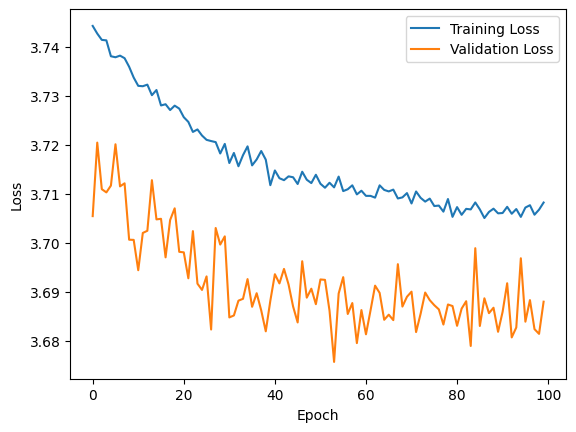

In [16]:
# Set training parameters
epochs = 100

# Train the model
history = model.fit(train_data, 
                    validation_data=test_data, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# Optional: Plotting training history
import matplotlib.pyplot as plt

# Plot loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
import numpy as np

# Number of samples to display for comparison
num_samples = 10

# Take a batch from the test set
for test_features, test_labels in test_data.take(1):
    # Make predictions on the batch
    predictions = model.predict(test_features)

    # Randomly select a few samples for comparison
    indices = np.random.choice(range(len(test_features)), num_samples, replace=False)
    print("Sample Comparisons (Predicted vs True):\n")
    
    for i in indices:
        pred = predictions[i]
        true = test_labels[i].numpy()
        
        # Classification predictions (first 96 elements)
        pred_p_id = pred[:96]
        true_p_id_index = np.argmax(true[:96])  # True p_id index

        # Sort predictions to find the top 4 likely patches
        top4_indices = np.argsort(pred_p_id)[-4:][::-1]
        top4_values = pred_p_id[top4_indices]

        # Display predicted and true `p_id`
        print(f"Sample {i + 1}:")
        print("Predicted p_id ->", ', '.join([f"{idx} ({val:.2e})" for idx, val in zip(top4_indices, top4_values)]))
        print(f"True p_id      -> {true_p_id_index}")

        # Surface coordinates and gn predictions for the top 2 patches
        print("Predicted (xi1, xi2) ->", ', '.join([f"patch {idx}: ({pred[96 + idx]:.2f}, {pred[192 + idx]:.2f})" for idx in top4_indices[:2]]))
        print(f"True (xi1, xi2)      -> ({true[96 + true_p_id_index]:.2f}, {true[192 + true_p_id_index]:.2f})")

        # gn predictions for the top 2 patches
        print("Predicted gn      ->", ', '.join([f"patch {idx}: {pred[288 + idx]:.3f}" for idx in top4_indices[:2]]))
        print(f"True gn           -> {true[288 + true_p_id_index]:.3f}")
        print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Sample Comparisons (Predicted vs True):

Sample 16:
Predicted p_id -> 61 (9.96e-01), 60 (3.56e-03), 63 (3.90e-08), 67 (4.51e-09)
True p_id      -> 67
Predicted (xi1, xi2) -> patch 61: (0.25, 0.08), patch 60: (0.28, 1.10)
True (xi1, xi2)      -> (0.63, 0.32)
Predicted gn      -> patch 61: 2.424, patch 60: 2.440
True gn           -> 2.412
------------------------------
Sample 31:
Predicted p_id -> 35 (1.00e+00), 34 (5.11e-08), 39 (2.73e-13), 47 (6.65e-18)
True p_id      -> 35
Predicted (xi1, xi2) -> patch 35: (0.29, 0.58), patch 34: (0.48, 1.00)
True (xi1, xi2)      -> (0.34, 0.61)
Predicted gn      -> patch 35: 0.853, patch 34: 0.831
True gn           -> 0.965
------------------------------
Sample 1:
Predicted p_id -> 25 (1.00e+00), 21 (4.82e-08), 29 (4.47e-13), 20 (1.45e-16)
True p_id      -> 25
Predicted (xi1, xi2) -> patch 25: (0.49, 0.77), patch 21: (0.76, 0.89)
True (xi1, xi2)      -> (0.38, 0.76)
Predicted gn      -> patch 25: -0.032, patch 21

In [11]:
data_frames = []
for file in glob.glob(csv_files_path):
    df = pd.read_csv(file, header=None)  # Load without headers
    if df.shape[1] == 7:                 # Ensure it has exactly 7 columns
        data_frames.append(df)           # Append if structure is correct
    else:
        print(f"Skipping file {file} due to unexpected number of columns: {df.shape[1]}")

# Concatenate all valid DataFrames
all_data = pd.concat(data_frames, ignore_index=True)

In [12]:
all_data = pd.read_csv('sampled_data_1_percent.csv')

In [13]:
np.array(test_features)[6]

array([-2.77511955,  0.90903301,  0.60452501])

In [14]:
all_data.shape
all_data = np.array(all_data)
print(min(all_data[:,0]),max(all_data[:,0]))
print(min(all_data[:,1]),max(all_data[:,1]))
print(min(all_data[:,2]),max(all_data[:,2]))
print(min(all_data[:,3]),max(all_data[:,3]))
print(min(all_data[:,4]),max(all_data[:,4]))
print(min(all_data[:,5]),max(all_data[:,5]))
print(min(all_data[:,6]),max(all_data[:,6]))

-4.574666709326302 4.849277650191799
-3.845417869175177 3.604469726681293
-2.608188522672036 2.5896162970226446
0.0 95.0
1.2254539169011228e-05 0.9999983531576394
1.4779910983747592e-05 0.999993652406488
-1.9319676956642824 3.3229442413895365


In [15]:
# Save the model in the .keras format
model_name = 'CLASSIF_REGRESS_128_512_FC_256_20EPOCHS'

model.save(model_name+'.keras')

import json

# Save the training history
with open(model_name+'.json', 'w') as f:
    json.dump(history.history, f)


# To later load doing:
# from tensorflow.keras.models import load_model
# model = load_model('my_model.keras')

# with open('training_history.json', 'r') as f:
#     history_data = json.load(f)

In [3]:
# To later load doing:
from tensorflow.keras.models import load_model
model = load_model('CLASSIF_REGRESS_128_512_CONV3D_256_20EPOCHS.keras')

# print(model.layers)

# def plot_conv_weights(model, layer_name):
#     filters, biases = model.get_layer(name=layer_name).get_weights()
#     n_filters = filters.shape[-1]
    
#     fig, axs = plt.subplots(1, n_filters, figsize=(20, 5))
#     for i in range(n_filters):
#         f = filters[:, :, :, i]
#         axs[i].imshow(f[:, :, 0], cmap='gray')
#         axs[i].axis('off')
#     plt.show()



# plot_conv_weights(model, 'conv1')  # Visualize filters of the first conv layer


TypeError: Could not locate function 'custom_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'custom_loss', 'registered_name': 'function'}